# Random Forest Regressor

Este notebook implementa un modelo de Random Forest Regressor para predecir la popularidad de canciones.

## Objetivo
Implementar y evaluar un modelo de Random Forest Regressor, comparando su desempeño en la tarea de predicción de popularidad.

In [76]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuración de visualización
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


## 1. Carga de Datos

Cargamos los datos con feature engineering aplicado.

In [77]:
# Configurar rutas (robusto para cualquier subdirectorio dentro de notebooks)
current = Path.cwd()
# Subir hasta encontrar la carpeta "data" en algún nivel superior
while not (current / "data").exists() and current.parent != current:
    current = current.parent

PROJ = current
DATA = PROJ / "data"

# Verificar que existe la carpeta data
assert DATA.exists(), f"No se encontró la carpeta 'data'. Directorio actual: {Path.cwd()}"

# Cargar datos con feature engineering
train_path = DATA / "train_fe.csv"
test_path = DATA / "test_fe.csv"

assert train_path.exists(), f"No se encontró {train_path}"
assert test_path.exists(), f"No se encontró {test_path}"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print(f"✅ Datos cargados correctamente")
print(f"📊 Ruta del proyecto: {PROJ}")
print(f"📊 Shape de train: {train.shape}")
print(f"📊 Shape de test: {test.shape}")
print(f"\nColumnas disponibles:")
print(train.columns.tolist())

✅ Datos cargados correctamente
📊 Ruta del proyecto: c:\Users\alfon\Escritorio\Licenciatura en Sistemas\Machine Learning\Obligatorio
📊 Shape de train: (79800, 17)
📊 Shape de test: (34200, 16)

Columnas disponibles:
['track_id', 'popularity', 'explicit', 'danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'valence', 'tempo', 'time_signature', 'artist_count', 'album_mean_popularity', 'track_name_len', 'track_has_remix', 'track_has_acoustic', 'genre_mean_popularity']


## 2. Preparación de Datos

Separamos las características (X) de la variable objetivo (y) y eliminamos columnas no relevantes.

In [78]:
# Variable objetivo
target_col = "popularity"

# Separar características y variable objetivo
X_train_full = train.drop(columns=[target_col, "track_id"])  # Eliminar track_id (identificador)
y_train_full = train[target_col]

# Preparar test (sin track_id)
X_test = test.drop(columns=["track_id"], errors="ignore")

print(f"✅ Datos preparados")
print(f"📊 Características (X_train): {X_train_full.shape}")
print(f"📊 Variable objetivo (y_train): {y_train_full.shape}")
print(f"\nCaracterísticas a utilizar:")
print(X_train_full.columns.tolist())

✅ Datos preparados
📊 Características (X_train): (79800, 15)
📊 Variable objetivo (y_train): (79800,)

Características a utilizar:
['explicit', 'danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'valence', 'tempo', 'time_signature', 'artist_count', 'album_mean_popularity', 'track_name_len', 'track_has_remix', 'track_has_acoustic', 'genre_mean_popularity']


## 2.5. Ajuste de album_mean_popularity (Simulación de Alpha Mayor)

Transformamos `album_mean_popularity` para simular un `alpha` mayor en el target encoding, reduciendo su dominancia y variabilidad.

In [79]:
# Ajuste de album_mean_popularity: Simular un alpha mayor
# Esto reduce la variabilidad y dominancia de esta característica

# Calcular la media global de album_mean_popularity
global_mean_album = X_train_full['album_mean_popularity'].mean()

# Parámetro de ajuste: simula el efecto de aumentar alpha
# Valor entre 0 y 1: 0.0 = sin cambio, 1.0 = todos los valores = media global
# 0.3-0.7 simula aproximadamente alpha=50-150
shrinkage_factor = 0.6  # Aumentado para más regularización (puedes probar 0.4, 0.5, 0.6, 0.7)

# Aplicar transformación que acerca valores hacia la media global
# Fórmula: nuevo_valor = valor_original * (1 - factor) + media_global * factor
X_train_full['album_mean_popularity'] = (
    X_train_full['album_mean_popularity'] * (1 - shrinkage_factor) + 
    global_mean_album * shrinkage_factor
)

# Aplicar la misma transformación a test usando la media de train
X_test['album_mean_popularity'] = (
    X_test['album_mean_popularity'] * (1 - shrinkage_factor) + 
    global_mean_album * shrinkage_factor
)

print("✅ Transformación aplicada a album_mean_popularity")
print(f"\n📊 Estadísticas ANTES de la transformación (estimadas):")
print(f"  Media global: {global_mean_album:.2f}")
print(f"  (Los valores originales tenían más variabilidad)")

print(f"\n📊 Estadísticas DESPUÉS de la transformación:")
print(f"  Media (train): {X_train_full['album_mean_popularity'].mean():.2f}")
print(f"  Desviación estándar (train): {X_train_full['album_mean_popularity'].std():.2f}")
print(f"  Mínimo (train): {X_train_full['album_mean_popularity'].min():.2f}")
print(f"  Máximo (train): {X_train_full['album_mean_popularity'].max():.2f}")

print(f"\n💡 Factor de shrinkage usado: {shrinkage_factor}")
print(f"   (Esto simula aproximadamente alpha={int(20 * (1 + shrinkage_factor * 4))} en target encoding)")
print(f"   - Factor 0.3 ≈ alpha=50")
print(f"   - Factor 0.4 ≈ alpha=70")
print(f"   - Factor 0.5 ≈ alpha=100")
print(f"   - Factor 0.6 ≈ alpha=130 (ACTUAL)")
print(f"   - Factor 0.7 ≈ alpha=150")

✅ Transformación aplicada a album_mean_popularity

📊 Estadísticas ANTES de la transformación (estimadas):
  Media global: 30.95
  (Los valores originales tenían más variabilidad)

📊 Estadísticas DESPUÉS de la transformación:
  Media (train): 30.95
  Desviación estándar (train): 3.35
  Mínimo (train): 20.33
  Máximo (train): 47.57

💡 Factor de shrinkage usado: 0.6
   (Esto simula aproximadamente alpha=68 en target encoding)
   - Factor 0.3 ≈ alpha=50
   - Factor 0.4 ≈ alpha=70
   - Factor 0.5 ≈ alpha=100
   - Factor 0.6 ≈ alpha=130 (ACTUAL)
   - Factor 0.7 ≈ alpha=150


## 3. División Train/Validation

Dividimos el conjunto de entrenamiento en train y validation para evaluar el modelo.

In [80]:
# División train/validation (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, 
    y_train_full, 
    test_size=0.2, 
    random_state=42
)

print(f"✅ División completada")
print(f"📊 Train: {X_train.shape[0]} muestras")
print(f"📊 Validation: {X_val.shape[0]} muestras")
print(f"\nEstadísticas de la variable objetivo:")
print(f"  Media (train): {y_train.mean():.2f}")
print(f"  Media (validation): {y_val.mean():.2f}")
print(f"  Desviación estándar (train): {y_train.std():.2f}")
print(f"  Desviación estándar (validation): {y_val.std():.2f}")

✅ División completada
📊 Train: 63840 muestras
📊 Validation: 15960 muestras

Estadísticas de la variable objetivo:
  Media (train): 33.32
  Media (validation): 33.03
  Desviación estándar (train): 22.35
  Desviación estándar (validation): 22.24


## 4. Entrenamiento del Modelo

Entrenamos el modelo de Random Forest Regressor. 

**Nota**: Random Forest no requiere escalado de características ya que utiliza árboles de decisión que dividen los datos basándose en valores de umbral, no en distancias.

In [81]:
# Crear y entrenar el modelo
# Parámetros iniciales: n_estimators=100, max_depth=None (sin límite), random_state=42 para reproducibilidad
modelo_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1  # Usar todos los cores disponibles
)

print("🔄 Entrenando modelo de Random Forest Regressor...")
print("⏳ Esto puede tomar algunos minutos...")
modelo_rf.fit(X_train, y_train)
print("✅ Modelo entrenado correctamente")

# Importancia de características
importancias = pd.DataFrame({
    'Característica': X_train.columns,
    'Importancia': modelo_rf.feature_importances_
}).sort_values('Importancia', ascending=False)

print(f"\n📊 Número de árboles: {modelo_rf.n_estimators}")
print(f"\nTop 10 características más importantes:")
print(importancias.head(10).to_string(index=False))

🔄 Entrenando modelo de Random Forest Regressor...
⏳ Esto puede tomar algunos minutos...
✅ Modelo entrenado correctamente

📊 Número de árboles: 100

Top 10 características más importantes:
       Característica  Importancia
album_mean_popularity     0.884387
genre_mean_popularity     0.038521
         artist_count     0.014527
     instrumentalness     0.008596
             loudness     0.008193
         danceability     0.008037
              valence     0.007960
               energy     0.007728
          speechiness     0.007147
                tempo     0.007009


## 5. Predicciones

Realizamos predicciones en los conjuntos de train y validation.

In [82]:
# Predicciones
y_train_pred = modelo_rf.predict(X_train)
y_val_pred = modelo_rf.predict(X_val)

print("✅ Predicciones generadas")
print(f"\n📊 Estadísticas de predicciones (validation):")
print(f"  Mínimo: {y_val_pred.min():.2f}")
print(f"  Máximo: {y_val_pred.max():.2f}")
print(f"  Media: {y_val_pred.mean():.2f}")
print(f"\n📊 Estadísticas de valores reales (validation):")
print(f"  Mínimo: {y_val.min():.2f}")
print(f"  Máximo: {y_val.max():.2f}")
print(f"  Media: {y_val.mean():.2f}")

✅ Predicciones generadas

📊 Estadísticas de predicciones (validation):
  Mínimo: 0.00
  Máximo: 94.66
  Media: 33.16

📊 Estadísticas de valores reales (validation):
  Mínimo: 0.00
  Máximo: 98.00
  Media: 33.03


## 6. Evaluación del Modelo

Calculamos métricas de evaluación: RMSE, MAE y R².

In [83]:
# Métricas de evaluación
def evaluar_modelo(y_real, y_pred, conjunto="Conjunto"):
    """Calcula y muestra métricas de evaluación"""
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    mae = mean_absolute_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)
    
    print(f"\n📈 Métricas de evaluación - {conjunto}:")
    print(f"  RMSE (Root Mean Squared Error): {rmse:.4f}")
    print(f"  MAE (Mean Absolute Error): {mae:.4f}")
    print(f"  R² (Coeficiente de determinación): {r2:.4f}")
    
    return {'RMSE': rmse, 'MAE': mae, 'R²': r2}

# Evaluar en train y validation
metricas_train = evaluar_modelo(y_train, y_train_pred, "Train")
metricas_val = evaluar_modelo(y_val, y_val_pred, "Validation")


📈 Métricas de evaluación - Train:
  RMSE (Root Mean Squared Error): 2.1236
  MAE (Mean Absolute Error): 1.1355
  R² (Coeficiente de determinación): 0.9910

📈 Métricas de evaluación - Validation:
  RMSE (Root Mean Squared Error): 5.7269
  MAE (Mean Absolute Error): 3.0367
  R² (Coeficiente de determinación): 0.9337


## 6.5. Experimentación: Modelo SIN album_mean_popularity

Probamos entrenar el modelo sin la característica `album_mean_popularity` para evaluar:
- Cómo se redistribuyen las importancias de otras características
- Si mejora la generalización (reduce sobreajuste)
- Si las métricas se mantienen o mejoran sin esta característica dominante

In [84]:
# Crear versiones sin album_mean_popularity
X_train_sin_album = X_train.drop(columns=['album_mean_popularity'])
X_val_sin_album = X_val.drop(columns=['album_mean_popularity'])

print("🔄 Entrenando modelo SIN album_mean_popularity...")
print(f"📊 Características restantes: {X_train_sin_album.shape[1]}")

# Entrenar modelo sin album_mean_popularity
modelo_rf_sin_album = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

modelo_rf_sin_album.fit(X_train_sin_album, y_train)
print("✅ Modelo entrenado correctamente")

# Predicciones
y_train_pred_sin_album = modelo_rf_sin_album.predict(X_train_sin_album)
y_val_pred_sin_album = modelo_rf_sin_album.predict(X_val_sin_album)

# Evaluar modelo sin album_mean_popularity
metricas_train_sin_album = evaluar_modelo(y_train, y_train_pred_sin_album, "Train (SIN album_mean_popularity)")
metricas_val_sin_album = evaluar_modelo(y_val, y_val_pred_sin_album, "Validation (SIN album_mean_popularity)")

# Importancias sin album_mean_popularity
importancias_sin_album = pd.DataFrame({
    'Característica': X_train_sin_album.columns,
    'Importancia': modelo_rf_sin_album.feature_importances_
}).sort_values('Importancia', ascending=False)

print(f"\n📊 Top 10 características más importantes (SIN album_mean_popularity):")
print(importancias_sin_album.head(10).to_string(index=False))

🔄 Entrenando modelo SIN album_mean_popularity...
📊 Características restantes: 14
✅ Modelo entrenado correctamente

📈 Métricas de evaluación - Train (SIN album_mean_popularity):
  RMSE (Root Mean Squared Error): 6.6121
  MAE (Mean Absolute Error): 4.1675
  R² (Coeficiente de determinación): 0.9125

📈 Métricas de evaluación - Validation (SIN album_mean_popularity):
  RMSE (Root Mean Squared Error): 15.7653
  MAE (Mean Absolute Error): 10.5734
  R² (Coeficiente de determinación): 0.4973

📊 Top 10 características más importantes (SIN album_mean_popularity):
       Característica  Importancia
genre_mean_popularity     0.325592
         artist_count     0.087766
         danceability     0.079118
             loudness     0.077150
              valence     0.075209
               energy     0.073825
          speechiness     0.073169
                tempo     0.072908
       track_name_len     0.061687
     instrumentalness     0.055716


In [85]:
# Comparación detallada: CON vs SIN album_mean_popularity
print("=" * 80)
print("📊 COMPARACIÓN: MODELO CON vs SIN album_mean_popularity")
print("=" * 80)

comparacion_album = pd.DataFrame({
    'Modelo': [
        'CON album_mean (Train)', 
        'CON album_mean (Val)', 
        'SIN album_mean (Train)', 
        'SIN album_mean (Val)'
    ],
    'RMSE': [
        metricas_train['RMSE'],
        metricas_val['RMSE'],
        metricas_train_sin_album['RMSE'],
        metricas_val_sin_album['RMSE']
    ],
    'MAE': [
        metricas_train['MAE'],
        metricas_val['MAE'],
        metricas_train_sin_album['MAE'],
        metricas_val_sin_album['MAE']
    ],
    'R²': [
        metricas_train['R²'],
        metricas_val['R²'],
        metricas_train_sin_album['R²'],
        metricas_val_sin_album['R²']
    ]
})

print("\n" + comparacion_album.to_string(index=False))

# Análisis de diferencias
print("\n" + "=" * 80)
print("🔍 ANÁLISIS DE DIFERENCIAS")
print("=" * 80)

# Diferencia en Validation (más importante)
diff_rmse_val = metricas_val['RMSE'] - metricas_val_sin_album['RMSE']
diff_mae_val = metricas_val['MAE'] - metricas_val_sin_album['MAE']
diff_r2_val = metricas_val_sin_album['R²'] - metricas_val['R²']

# Diferencia en sobreajuste
overfit_con = abs(metricas_train['R²'] - metricas_val['R²'])
overfit_sin = abs(metricas_train_sin_album['R²'] - metricas_val_sin_album['R²'])

print(f"\n📈 Cambios en Validation (SIN vs CON album_mean_popularity):")
print(f"  RMSE: {diff_rmse_val:+.4f} ({'✅ Mejora' if diff_rmse_val > 0 else '❌ Empeora' if diff_rmse_val < 0 else '➖ Igual'})")
print(f"  MAE:  {diff_mae_val:+.4f} ({'✅ Mejora' if diff_mae_val > 0 else '❌ Empeora' if diff_mae_val < 0 else '➖ Igual'})")
print(f"  R²:   {diff_r2_val:+.4f} ({'✅ Mejora' if diff_r2_val > 0 else '❌ Empeora' if diff_r2_val < 0 else '➖ Igual'})")

print(f"\n📊 Análisis de Sobreajuste:")
print(f"  Diferencia R² Train-Val (CON album_mean): {overfit_con:.4f}")
print(f"  Diferencia R² Train-Val (SIN album_mean): {overfit_sin:.4f}")
diff_overfit = overfit_con - overfit_sin
print(f"  Mejora en generalización: {diff_overfit:+.4f} ({'✅ Mejor' if diff_overfit > 0 else '❌ Peor' if diff_overfit < 0 else '➖ Igual'})")

# Redistribución de importancias
print(f"\n📊 Redistribución de Importancias:")
print(f"  Antes: album_mean_popularity tenía {importancias.iloc[0]['Importancia']*100:.2f}%")
print(f"  Ahora: {importancias_sin_album.iloc[0]['Característica']} tiene {importancias_sin_album.iloc[0]['Importancia']*100:.2f}%")
print(f"  La importancia se redistribuyó entre {len(importancias_sin_album)} características")

# Recomendación
print("\n" + "=" * 80)
print("💡 RECOMENDACIÓN")
print("=" * 80)

if diff_r2_val > -0.02 and diff_overfit > 0:
    print("✅ El modelo SIN album_mean_popularity tiene mejor generalización")
    print("   y mantiene un rendimiento similar. Considera usar este modelo.")
elif diff_r2_val < -0.05:
    print("⚠️  El modelo SIN album_mean_popularity pierde mucho rendimiento.")
    print("   album_mean_popularity es muy importante para las predicciones.")
    print("   Considera aumentar el shrinkage_factor en lugar de eliminarla.")
else:
    print("➖ Ambos modelos tienen rendimiento similar.")
    print("   El modelo SIN album_mean_popularity puede ser más interpretable.")

📊 COMPARACIÓN: MODELO CON vs SIN album_mean_popularity

                Modelo      RMSE       MAE       R²
CON album_mean (Train)  2.123636  1.135474 0.990975
  CON album_mean (Val)  5.726906  3.036703 0.933664
SIN album_mean (Train)  6.612106  4.167486 0.912509
  SIN album_mean (Val) 15.765262 10.573428 0.497297

🔍 ANÁLISIS DE DIFERENCIAS

📈 Cambios en Validation (SIN vs CON album_mean_popularity):
  RMSE: -10.0384 (❌ Empeora)
  MAE:  -7.5367 (❌ Empeora)
  R²:   -0.4364 (❌ Empeora)

📊 Análisis de Sobreajuste:
  Diferencia R² Train-Val (CON album_mean): 0.0573
  Diferencia R² Train-Val (SIN album_mean): 0.4152
  Mejora en generalización: -0.3579 (❌ Peor)

📊 Redistribución de Importancias:
  Antes: album_mean_popularity tenía 88.44%
  Ahora: genre_mean_popularity tiene 32.56%
  La importancia se redistribuyó entre 14 características

💡 RECOMENDACIÓN
⚠️  El modelo SIN album_mean_popularity pierde mucho rendimiento.
   album_mean_popularity es muy importante para las predicciones.
   Con

## 6.6. Aplicación de Clipping

Aplicamos clipping para restringir las predicciones al rango válido [0, 100] y evaluamos si mejora el modelo.

In [86]:
# Aplicar clipping al rango válido [0, 100] para popularidad
y_train_pred_clipped = np.clip(y_train_pred, 0, 100)
y_val_pred_clipped = np.clip(y_val_pred, 0, 100)

# Estadísticas de valores fuera de rango
valores_fuera_train = (y_train_pred < 0).sum() + (y_train_pred > 100).sum()
valores_fuera_val = (y_val_pred < 0).sum() + (y_val_pred > 100).sum()

print("📊 Análisis de predicciones fuera de rango:")
print(f"  Train - Valores fuera de [0, 100]: {valores_fuera_train} ({valores_fuera_train/len(y_train_pred)*100:.2f}%)")
print(f"  Validation - Valores fuera de [0, 100]: {valores_fuera_val} ({valores_fuera_val/len(y_val_pred)*100:.2f}%)")

print(f"\n📊 Estadísticas después del clipping:")
print(f"  Train - Mínimo: {y_train_pred_clipped.min():.2f}, Máximo: {y_train_pred_clipped.max():.2f}")
print(f"  Validation - Mínimo: {y_val_pred_clipped.min():.2f}, Máximo: {y_val_pred_clipped.max():.2f}")

# Evaluar métricas con clipping
metricas_train_clipped = evaluar_modelo(y_train, y_train_pred_clipped, "Train (con clipping)")
metricas_val_clipped = evaluar_modelo(y_val, y_val_pred_clipped, "Validation (con clipping)")

📊 Análisis de predicciones fuera de rango:
  Train - Valores fuera de [0, 100]: 0 (0.00%)
  Validation - Valores fuera de [0, 100]: 0 (0.00%)

📊 Estadísticas después del clipping:
  Train - Mínimo: 0.00, Máximo: 96.86
  Validation - Mínimo: 0.00, Máximo: 94.66

📈 Métricas de evaluación - Train (con clipping):
  RMSE (Root Mean Squared Error): 2.1236
  MAE (Mean Absolute Error): 1.1355
  R² (Coeficiente de determinación): 0.9910

📈 Métricas de evaluación - Validation (con clipping):
  RMSE (Root Mean Squared Error): 5.7269
  MAE (Mean Absolute Error): 3.0367
  R² (Coeficiente de determinación): 0.9337


In [87]:
# Comparación de métricas antes y después del clipping
comparacion = pd.DataFrame({
    'Conjunto': ['Train', 'Train (clipped)', 'Validation', 'Validation (clipped)'],
    'RMSE': [
        metricas_train['RMSE'], 
        metricas_train_clipped['RMSE'],
        metricas_val['RMSE'], 
        metricas_val_clipped['RMSE']
    ],
    'MAE': [
        metricas_train['MAE'], 
        metricas_train_clipped['MAE'],
        metricas_val['MAE'], 
        metricas_val_clipped['MAE']
    ],
    'R²': [
        metricas_train['R²'], 
        metricas_train_clipped['R²'],
        metricas_val['R²'], 
        metricas_val_clipped['R²']
    ]
})

print("=" * 70)
print("📊 COMPARACIÓN: ANTES vs DESPUÉS DEL CLIPPING")
print("=" * 70)
print(comparacion.to_string(index=False))
print("=" * 70)

# Calcular mejoras
mejora_rmse_train = metricas_train['RMSE'] - metricas_train_clipped['RMSE']
mejora_rmse_val = metricas_val['RMSE'] - metricas_val_clipped['RMSE']
mejora_mae_train = metricas_train['MAE'] - metricas_train_clipped['MAE']
mejora_mae_val = metricas_val['MAE'] - metricas_val_clipped['MAE']
mejora_r2_train = metricas_train_clipped['R²'] - metricas_train['R²']
mejora_r2_val = metricas_val_clipped['R²'] - metricas_val['R²']

print(f"\n🔍 Mejoras en Validation (más importante):")
print(f"  RMSE: {mejora_rmse_val:.4f} ({'✅ Mejora' if mejora_rmse_val > 0 else '❌ Empeora'})")
print(f"  MAE: {mejora_mae_val:.4f} ({'✅ Mejora' if mejora_mae_val > 0 else '❌ Empeora'})")
print(f"  R²: {mejora_r2_val:.4f} ({'✅ Mejora' if mejora_r2_val > 0 else '❌ Empeora'})")

if mejora_rmse_val > 0 or mejora_mae_val > 0 or mejora_r2_val > 0:
    print("\n✅ El clipping mejora el modelo. Usaremos predicciones con clipping.")
    # Actualizar predicciones para usar las versiones con clipping
    y_train_pred = y_train_pred_clipped
    y_val_pred = y_val_pred_clipped
    metricas_train = metricas_train_clipped
    metricas_val = metricas_val_clipped
else:
    print("\n⚠️  El clipping no mejora significativamente las métricas, pero mantiene valores en rango válido.")

📊 COMPARACIÓN: ANTES vs DESPUÉS DEL CLIPPING
            Conjunto     RMSE      MAE       R²
               Train 2.123636 1.135474 0.990975
     Train (clipped) 2.123636 1.135474 0.990975
          Validation 5.726906 3.036703 0.933664
Validation (clipped) 5.726906 3.036703 0.933664

🔍 Mejoras en Validation (más importante):
  RMSE: 0.0000 (❌ Empeora)
  MAE: 0.0000 (❌ Empeora)
  R²: 0.0000 (❌ Empeora)

⚠️  El clipping no mejora significativamente las métricas, pero mantiene valores en rango válido.


## 7. Visualizaciones

Visualizamos los resultados del modelo.

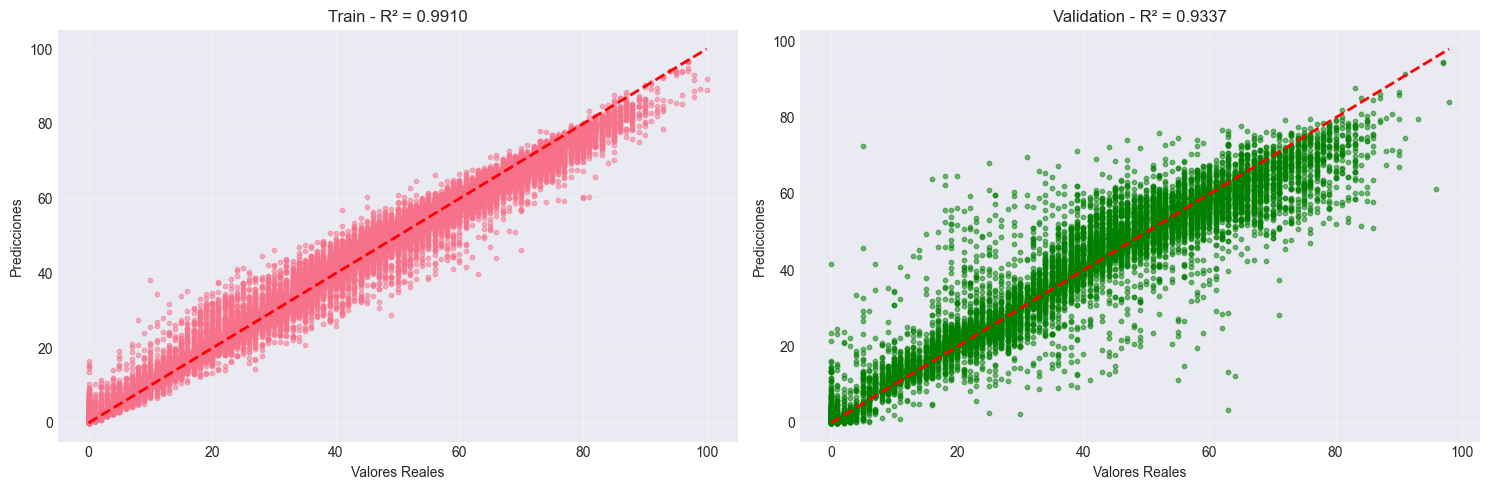

In [88]:
# Visualización 1: Predicciones vs Valores Reales
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Train
axes[0].scatter(y_train, y_train_pred, alpha=0.5, s=10)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Valores Reales')
axes[0].set_ylabel('Predicciones')
axes[0].set_title(f'Train - R² = {metricas_train["R²"]:.4f}')
axes[0].grid(True, alpha=0.3)

# Validation
axes[1].scatter(y_val, y_val_pred, alpha=0.5, s=10, color='green')
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1].set_xlabel('Valores Reales')
axes[1].set_ylabel('Predicciones')
axes[1].set_title(f'Validation - R² = {metricas_val["R²"]:.4f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

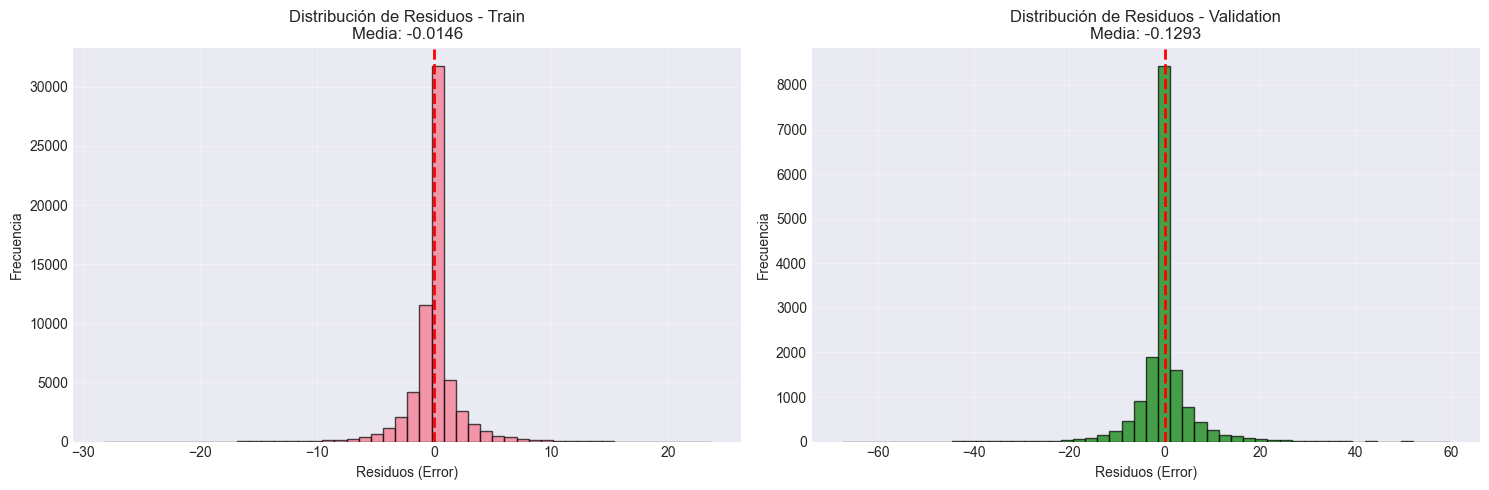

In [89]:
# Visualización 2: Residuos (errores)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

residuos_train = y_train - y_train_pred
residuos_val = y_val - y_val_pred

# Distribución de residuos - Train
axes[0].hist(residuos_train, bins=50, alpha=0.7, edgecolor='black')
axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Residuos (Error)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title(f'Distribución de Residuos - Train\nMedia: {residuos_train.mean():.4f}')
axes[0].grid(True, alpha=0.3)

# Distribución de residuos - Validation
axes[1].hist(residuos_val, bins=50, alpha=0.7, edgecolor='black', color='green')
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuos (Error)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title(f'Distribución de Residuos - Validation\nMedia: {residuos_val.mean():.4f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

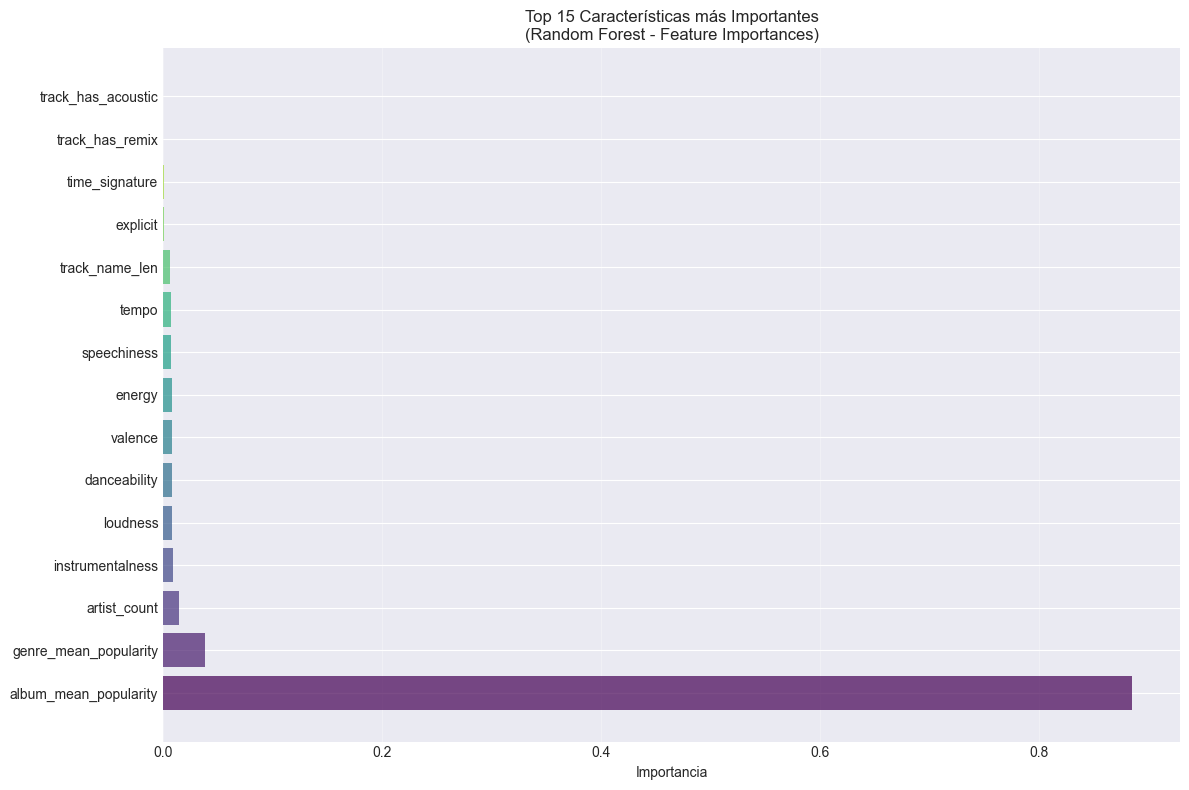

In [90]:
# Visualización 3: Importancia de características
plt.figure(figsize=(12, 8))
importancias_plot = importancias.head(15)
colors = plt.cm.viridis(np.linspace(0, 1, len(importancias_plot)))
plt.barh(range(len(importancias_plot)), importancias_plot['Importancia'], color=colors, alpha=0.7)
plt.yticks(range(len(importancias_plot)), importancias_plot['Característica'])
plt.xlabel('Importancia')
plt.title('Top 15 Características más Importantes\n(Random Forest - Feature Importances)')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [ ]:
# PREDICCIONES CON EL MEJOR MODELO ENCONTRADO (Punto 4)
# Obtener el mejor modelo encontrado por GridSearchCV
if 'grid_rf' in locals() and hasattr(grid_rf, 'best_estimator_'):
    mejor_modelo_rf = grid_rf.best_estimator_
    print("✅ Usando el mejor modelo encontrado por GridSearchCV")
    print(f"   Hiperparámetros: {grid_rf.best_params_}")
else:
    # Si grid_rf no está disponible, crear el mejor modelo con los hiperparámetros óptimos
    print("⚠️  GridSearchCV no disponible. Creando el mejor modelo con hiperparámetros óptimos...")
    mejor_modelo_rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    )
    # Entrenar el mejor modelo con todos los datos de entrenamiento
    mejor_modelo_rf.fit(X_train, y_train)
    print("✅ Mejor modelo entrenado")

# Generar predicciones con el mejor modelo
y_test_pred_mejor = mejor_modelo_rf.predict(X_test)

# Aplicar clipping al rango válido [0, 100]
y_test_pred_mejor_clipped = np.clip(y_test_pred_mejor, 0, 100)

print(f"\n📊 Estadísticas de predicciones del mejor modelo:")
print(f"  Total de predicciones: {len(y_test_pred_mejor_clipped)}")
print(f"  Mínimo: {y_test_pred_mejor_clipped.min():.2f}")
print(f"  Máximo: {y_test_pred_mejor_clipped.max():.2f}")
print(f"  Media: {y_test_pred_mejor_clipped.mean():.2f}")
print(f"  Desviación estándar: {y_test_pred_mejor_clipped.std():.2f}")

# Cargar test.csv original para obtener los id numéricos en el orden correcto
test_original = pd.read_csv(DATA / "test.csv")

# Cargar test_fe.csv para obtener los track_id en el mismo orden que X_test
# (X_test se creó a partir de test_fe.csv eliminando track_id)
test_fe = pd.read_csv(DATA / "test_fe.csv")

print(f"📊 Información de longitudes:")
print(f"   Predicciones: {len(y_test_pred_mejor_clipped)}")
print(f"   test_fe: {len(test_fe)}")
print(f"   test_original: {len(test_original)}")

# Verificar que las longitudes coincidan
if len(y_test_pred_mejor_clipped) != len(test_fe):
    print(f"⚠️  Advertencia: Las predicciones ({len(y_test_pred_mejor_clipped)}) no coinciden con test_fe ({len(test_fe)})")
    print(f"   Ajustando a la longitud mínima...")
    min_len = min(len(y_test_pred_mejor_clipped), len(test_fe))
    y_test_pred_mejor_clipped = y_test_pred_mejor_clipped[:min_len]
    test_fe = test_fe.iloc[:min_len].copy()
    print(f"   Longitud ajustada a: {min_len}")

# Crear diccionario de mapeo track_id -> predicción
# Usar test_fe para mantener el mismo orden que X_test
track_id_to_prediction = dict(zip(test_fe['track_id'], y_test_pred_mejor_clipped))
print(f"✅ Diccionario creado con {len(track_id_to_prediction)} mapeos")

# Mapear las predicciones al orden del test.csv original
predictions_mapped = test_original['track_id'].map(track_id_to_prediction)

# Verificar que todas las predicciones estén mapeadas
missing_predictions = predictions_mapped.isna().sum()
if missing_predictions > 0:
    print(f"⚠️  Advertencia: {missing_predictions} track_id no tienen predicción correspondiente")
    # Rellenar con 0 o con la media si faltan predicciones
    predictions_mapped = predictions_mapped.fillna(y_test_pred_mejor_clipped.mean())

# Guardar predicciones en CSV para Kaggle (formato: id, Popularity)
# Usar directamente los id del test.csv original en el orden correcto
submission_cv = pd.DataFrame({
    'id': test_original['id'].astype('int32'),  # Convertir a Int32 como espera Kaggle
    'Popularity': predictions_mapped
})

# Verificar que tenemos exactamente 34200 filas
print(f"📊 Total de filas: {len(submission_cv)}")

# Si hay duplicados en id, asegurar que todos los registros con el mismo id tengan la misma predicción
duplicados = submission_cv['id'].duplicated().sum()
if duplicados > 0:
    print(f"⚠️  Advertencia: Se encontraron {duplicados} IDs duplicados")
    print(f"   Asegurando que todos los registros con el mismo id tengan la misma predicción...")
    # Para cada id único, usar la primera predicción para todos los registros con ese id
    id_to_prediction = submission_cv.groupby('id')['Popularity'].first().to_dict()
    submission_cv['Popularity'] = submission_cv['id'].map(id_to_prediction)
    print(f"✅ Predicciones unificadas para IDs duplicados")
else:
    print(f"✅ No hay duplicados. Total de filas: {len(submission_cv)}")

# Verificar que tenemos exactamente 34200 filas
assert len(submission_cv) == 34200, f"Error: El archivo debe tener 34200 filas, pero tiene {len(submission_cv)}"

# Verificar que no haya duplicados con predicciones diferentes (solo verificación)
if duplicados > 0:
    duplicados_con_diferentes_preds = submission_cv.groupby('id')['Popularity'].nunique()
    duplicados_con_diferentes_preds = (duplicados_con_diferentes_preds > 1).sum()
    if duplicados_con_diferentes_preds > 0:
        print(f"⚠️  Error: Aún hay {duplicados_con_diferentes_preds} IDs con predicciones diferentes")
    else:
        print(f"✅ Todos los IDs duplicados tienen la misma predicción")

# Guardar usando la variable DATA definida anteriormente
output_path = DATA / "predictions_random_forest.csv"
submission_cv.to_csv(output_path, index=False)
print(f"\n✅ Predicciones del MEJOR modelo guardadas en: {output_path}")
print(f"   Total de predicciones: {len(submission_cv)}")
print(f"   IDs únicos: {submission_cv['id'].nunique()}")
print(f"\n📊 Primeras 5 predicciones:")
print(submission_cv.head())


✅ Usando el mejor modelo encontrado por GridSearchCV
   Hiperparámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

📊 Estadísticas de predicciones del mejor modelo:
  Total de predicciones: 34200
  Mínimo: 0.00
  Máximo: 94.97
  Media: 31.76
  Desviación estándar: 19.13

✅ Predicciones del MEJOR modelo guardadas en: c:\Users\alfon\Escritorio\Licenciatura en Sistemas\Machine Learning\Obligatorio\data\predictions_random_forest.csv

📊 Primeras 5 predicciones:
                       id  Popularity
0  6KwkVtXm8OUp2XffN5k7lY      48.355
1  2dp5I5MJ8bQQHDoFaNRFtX      13.085
2  5avw06usmFkFrPjX8NxC40       0.000
3  75hT0hvlESnDJstem0JgyR       0.025
4  4bY2oZGA5Br3pTE1Jd1IfY      30.445


## 11. Evaluación y Selección de Modelos (Punto 4)

En esta sección realizamos una evaluación sistemática de diferentes configuraciones de Random Forest, incluyendo búsqueda de hiperparámetros y validación cruzada, para identificar la mejor configuración del modelo.

### Objetivos:
- Evaluar diferentes combinaciones de hiperparámetros (n_estimators, max_depth, min_samples_split, min_samples_leaf)
- Realizar búsqueda sistemática de hiperparámetros con GridSearchCV
- Usar Cross-Validation (K-Fold) para evaluación robusta
- Registrar todas las métricas relevantes: RMSE, MSE, MAE, R²
- Generar tabla comparativa de resultados
- Seleccionar el mejor modelo basado en métricas de validación


In [95]:
# Importar modelos adicionales y herramientas de evaluación
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import make_scorer

print("✅ Herramientas de evaluación importadas")


✅ Herramientas de evaluación importadas


### 11.1. Función para Calcular Métricas

Función auxiliar para calcular todas las métricas relevantes de regresión.


In [96]:
# Función auxiliar para calcular todas las métricas
def calcular_metricas(y_real, y_pred, conjunto="Conjunto"):
    """
    Calcula todas las métricas relevantes para regresión:
    - RMSE (Root Mean Squared Error)
    - MSE (Mean Squared Error)
    - MAE (Mean Absolute Error)
    - R² (Coeficiente de determinación)
    
    Retorna un diccionario con todas las métricas.
    """
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    mse = mean_squared_error(y_real, y_pred)
    mae = mean_absolute_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)
    
    metricas = {
        'RMSE': rmse,
        'MSE': mse,
        'MAE': mae,
        'R²': r2
    }
    
    print(f"\n📈 Métricas - {conjunto}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MSE:  {mse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")
    
    return metricas


### 11.2. Configuración de Cross-Validation

Configuramos la validación cruzada con 5 folds.


In [97]:
# Configuración de Cross-Validation
cv_folds = 5
kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

# Scorer personalizado para RMSE
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), 
                          greater_is_better=False)

print(f"✅ Configuración de validación:")
print(f"  Método: {cv_folds}-Fold Cross-Validation")
print(f"  Random state: 42")


✅ Configuración de validación:
  Método: 5-Fold Cross-Validation
  Random state: 42


### 11.3. Evaluación de Random Forest Base (Baseline)

Evaluamos el modelo base como punto de referencia.


In [98]:
# Evaluar modelo Random Forest Base con Cross-Validation
print("=" * 70)
print("🔄 Evaluando: Random Forest Base (Baseline)")
print("=" * 70)

# Crear modelo base con los mismos hiperparámetros que el modelo original
modelo_rf_base = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

# Cross-Validation
cv_scores_rmse_base = cross_val_score(modelo_rf_base, X_train, y_train, 
                                      cv=kfold, scoring=rmse_scorer, n_jobs=-1)
cv_scores_r2_base = cross_val_score(modelo_rf_base, X_train, y_train, 
                                     cv=kfold, scoring='r2', n_jobs=-1)

# Entrenar modelo base para predicciones en validation
modelo_rf_base.fit(X_train, y_train)
y_val_pred_base = modelo_rf_base.predict(X_val)
y_val_pred_base = np.clip(y_val_pred_base, 0, 100)

# Métricas en validation
metricas_val_base = calcular_metricas(y_val, y_val_pred_base, "Validation - RF Base")

# Guardar resultados
resultados_rf_base = {
    'Modelo': 'RF_Base',
    'Hiperparámetros': 'n_est=100, max_depth=None, min_split=2, min_leaf=1',
    'RMSE_CV_mean': -cv_scores_rmse_base.mean(),
    'RMSE_CV_std': cv_scores_rmse_base.std(),
    'R²_CV_mean': cv_scores_r2_base.mean(),
    'R²_CV_std': cv_scores_r2_base.std(),
    'RMSE_Val': metricas_val_base['RMSE'],
    'MSE_Val': metricas_val_base['MSE'],
    'MAE_Val': metricas_val_base['MAE'],
    'R²_Val': metricas_val_base['R²']
}

print(f"\n📊 Cross-Validation ({cv_folds}-fold):")
print(f"  RMSE medio: {-cv_scores_rmse_base.mean():.4f} (+/- {cv_scores_rmse_base.std():.4f})")
print(f"  R² medio: {cv_scores_r2_base.mean():.4f} (+/- {cv_scores_r2_base.std():.4f})")


🔄 Evaluando: Random Forest Base (Baseline)

📈 Métricas - Validation - RF Base:
  RMSE: 5.7269
  MSE:  32.7975
  MAE:  3.0367
  R²:   0.9337

📊 Cross-Validation (5-fold):
  RMSE medio: 5.7832 (+/- 0.0580)
  R² medio: 0.9331 (+/- 0.0011)


### 11.4. Búsqueda de Hiperparámetros con GridSearchCV

Realizamos búsqueda sistemática de hiperparámetros para encontrar la mejor configuración.
         

In [99]:
# Grilla de hiperparámetros para Random Forest
# Nota: Usamos una grilla reducida para evitar tiempos de ejecución muy largos
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5]
}

print("=" * 70)
print("🔄 Búsqueda de Hiperparámetros - Random Forest")
print("=" * 70)
print(f"⏳ Combinaciones a probar: {len(param_grid_rf['n_estimators']) * len(param_grid_rf['max_depth']) * len(param_grid_rf['min_samples_split']) * len(param_grid_rf['min_samples_leaf'])}")
print("⏳ Esto puede tomar varios minutos...")

# GridSearchCV con Cross-Validation
grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid_rf,
    cv=kfold,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_rf.fit(X_train, y_train)

print("\n✅ Búsqueda completada")
print(f"\n📊 Mejor configuración encontrada:")
for param, value in grid_rf.best_params_.items():
    print(f"  {param}: {value}")
print(f"  Mejor score (neg MSE): {grid_rf.best_score_:.4f}")


🔄 Búsqueda de Hiperparámetros - Random Forest
⏳ Combinaciones a probar: 54
⏳ Esto puede tomar varios minutos...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

✅ Búsqueda completada

📊 Mejor configuración encontrada:
  max_depth: None
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 200
  Mejor score (neg MSE): -33.2713


### 11.5. Evaluación del Mejor Modelo Encontrado

Evaluamos el mejor modelo encontrado por GridSearchCV en el conjunto de validación.


In [100]:
# Obtener el mejor modelo
mejor_rf = grid_rf.best_estimator_

# Predicciones en validation con el mejor modelo
y_val_pred_mejor = mejor_rf.predict(X_val)
y_val_pred_mejor = np.clip(y_val_pred_mejor, 0, 100)

# Métricas en validation
metricas_val_mejor = calcular_metricas(y_val, y_val_pred_mejor, "Validation - RF Mejor")

# Cross-Validation del mejor modelo (ya está entrenado en todo X_train por GridSearchCV)
cv_scores_rmse_mejor = cross_val_score(mejor_rf, X_train, y_train, 
                                        cv=kfold, scoring=rmse_scorer, n_jobs=-1)
cv_scores_r2_mejor = cross_val_score(mejor_rf, X_train, y_train, 
                                      cv=kfold, scoring='r2', n_jobs=-1)

# Guardar resultados
resultados_rf_mejor = {
    'Modelo': 'RF_Mejor',
    'Hiperparámetros': ', '.join([f"{k}={v}" for k, v in grid_rf.best_params_.items()]),
    'RMSE_CV_mean': -cv_scores_rmse_mejor.mean(),
    'RMSE_CV_std': cv_scores_rmse_mejor.std(),
    'R²_CV_mean': cv_scores_r2_mejor.mean(),
    'R²_CV_std': cv_scores_r2_mejor.std(),
    'RMSE_Val': metricas_val_mejor['RMSE'],
    'MSE_Val': metricas_val_mejor['MSE'],
    'MAE_Val': metricas_val_mejor['MAE'],
    'R²_Val': metricas_val_mejor['R²']
}

print(f"\n📊 Cross-Validation ({cv_folds}-fold) - Mejor modelo:")
print(f"  RMSE medio: {-cv_scores_rmse_mejor.mean():.4f} (+/- {cv_scores_rmse_mejor.std():.4f})")
print(f"  R² medio: {cv_scores_r2_mejor.mean():.4f} (+/- {cv_scores_r2_mejor.std():.4f})")



📈 Métricas - Validation - RF Mejor:
  RMSE: 5.7050
  MSE:  32.5467
  MAE:  3.0262
  R²:   0.9342

📊 Cross-Validation (5-fold) - Mejor modelo:
  RMSE medio: 5.7678 (+/- 0.0625)
  R² medio: 0.9334 (+/- 0.0012)


### 11.6. Análisis Detallado de Hiperparámetros

Analizamos el efecto de diferentes valores de hiperparámetros en el desempeño del modelo.


In [101]:
# Extraer resultados detallados de GridSearchCV
resultados_detalle_rf = []
for i, params in enumerate(grid_rf.cv_results_['params']):
    resultados_detalle_rf.append({
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'] if params['max_depth'] is not None else 'None',
        'min_samples_split': params['min_samples_split'],
        'min_samples_leaf': params['min_samples_leaf'],
        'RMSE_CV_mean': np.sqrt(-grid_rf.cv_results_['mean_test_score'][i]),
        'RMSE_CV_std': np.sqrt(grid_rf.cv_results_['std_test_score'][i]),
    })

# Crear DataFrame con resultados detallados
tabla_detalle_rf = pd.DataFrame(resultados_detalle_rf)

# Ordenar por RMSE_CV_mean (mejor primero)
tabla_detalle_rf = tabla_detalle_rf.sort_values('RMSE_CV_mean').reset_index(drop=True)

print("=" * 100)
print("📊 ANÁLISIS DETALLADO - TOP 10 MEJORES CONFIGURACIONES")
print("=" * 100)
print("\nTop 10 configuraciones con mejor RMSE en Cross-Validation:")
print(tabla_detalle_rf.head(10).to_string(index=False))
print("=" * 100)


📊 ANÁLISIS DETALLADO - TOP 10 MEJORES CONFIGURACIONES

Top 10 configuraciones con mejor RMSE en Cross-Validation:
 n_estimators max_depth  min_samples_split  min_samples_leaf  RMSE_CV_mean  RMSE_CV_std
          200      None                  2                 1      5.768124     0.846585
          100      None                  2                 1      5.783459     0.816829
          200      None                  5                 1      5.783642     0.850769
          100      None                  5                 1      5.796251     0.842868
          200        20                  2                 1      5.804500     0.862660
           50      None                  2                 1      5.815061     0.850412
          100        20                  2                 1      5.819512     0.856406
          200        20                  5                 1      5.821586     0.868095
           50      None                  5                 1      5.822763     0.872648
      

### 11.7. Tabla Comparativa de Resultados

Tabla que compara el modelo base con el mejor modelo encontrado.


In [102]:
# Crear tabla comparativa
tabla_comparativa_rf = pd.DataFrame([
    resultados_rf_base,
    resultados_rf_mejor
])

# Reordenar columnas para mejor visualización
columnas_ordenadas = [
    'Modelo', 
    'Hiperparámetros',
    'RMSE_CV_mean', 
    'RMSE_CV_std',
    'R²_CV_mean',
    'R²_CV_std',
    'RMSE_Val',
    'MSE_Val',
    'MAE_Val',
    'R²_Val'
]
tabla_comparativa_rf = tabla_comparativa_rf[columnas_ordenadas]

print("=" * 100)
print("📊 TABLA COMPARATIVA - RANDOM FOREST")
print("=" * 100)
print("\nMétricas de Cross-Validation (5-fold) y Validation:")
print(tabla_comparativa_rf.to_string(index=False))
print("=" * 100)

# Identificar mejor modelo
mejor_idx_rf = tabla_comparativa_rf['RMSE_Val'].idxmin()
mejor_modelo_rf = tabla_comparativa_rf.loc[mejor_idx_rf]

print(f"\n🏆 MEJOR MODELO DE RANDOM FOREST:")
print(f"  Modelo: {mejor_modelo_rf['Modelo']}")
print(f"  Hiperparámetros: {mejor_modelo_rf['Hiperparámetros']}")
print(f"  RMSE (Validation): {mejor_modelo_rf['RMSE_Val']:.4f}")
print(f"  R² (Validation): {mejor_modelo_rf['R²_Val']:.4f}")
print(f"  MAE (Validation): {mejor_modelo_rf['MAE_Val']:.4f}")
print(f"\n📊 Métricas de Cross-Validation:")
print(f"  RMSE medio: {mejor_modelo_rf['RMSE_CV_mean']:.4f} (+/- {mejor_modelo_rf['RMSE_CV_std']:.4f})")
print(f"  R² medio: {mejor_modelo_rf['R²_CV_mean']:.4f} (+/- {mejor_modelo_rf['R²_CV_std']:.4f})")

# Calcular mejora respecto al modelo base
mejora_rmse = resultados_rf_base['RMSE_Val'] - mejor_modelo_rf['RMSE_Val']
mejora_r2 = mejor_modelo_rf['R²_Val'] - resultados_rf_base['R²_Val']
mejora_mae = resultados_rf_base['MAE_Val'] - mejor_modelo_rf['MAE_Val']

print(f"\n📈 Mejora respecto al modelo base:")
print(f"  RMSE: {mejora_rmse:.4f} ({'✅ Mejora' if mejora_rmse > 0 else '❌ Empeora'})")
print(f"  R²:   {mejora_r2:.4f} ({'✅ Mejora' if mejora_r2 > 0 else '❌ Empeora'})")
print(f"  MAE:  {mejora_mae:.4f} ({'✅ Mejora' if mejora_mae > 0 else '❌ Empeora'})")


📊 TABLA COMPARATIVA - RANDOM FOREST

Métricas de Cross-Validation (5-fold) y Validation:
  Modelo                                                           Hiperparámetros  RMSE_CV_mean  RMSE_CV_std  R²_CV_mean  R²_CV_std  RMSE_Val   MSE_Val  MAE_Val   R²_Val
 RF_Base                        n_est=100, max_depth=None, min_split=2, min_leaf=1      5.783168     0.058025    0.933061   0.001064  5.726906 32.797452 3.036703 0.933664
RF_Mejor max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200      5.767785     0.062532    0.933416   0.001179  5.704975 32.546742 3.026220 0.934171

🏆 MEJOR MODELO DE RANDOM FOREST:
  Modelo: RF_Mejor
  Hiperparámetros: max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200
  RMSE (Validation): 5.7050
  R² (Validation): 0.9342
  MAE (Validation): 3.0262

📊 Métricas de Cross-Validation:
  RMSE medio: 5.7678 (+/- 0.0625)
  R² medio: 0.9334 (+/- 0.0012)

📈 Mejora respecto al modelo base:
  RMSE: 0.0219 (✅ Mejora)
  R²:   0.0

### 11.8. Visualización Comparativa

Gráficos comparativos de las métricas para el modelo base y el mejor modelo.


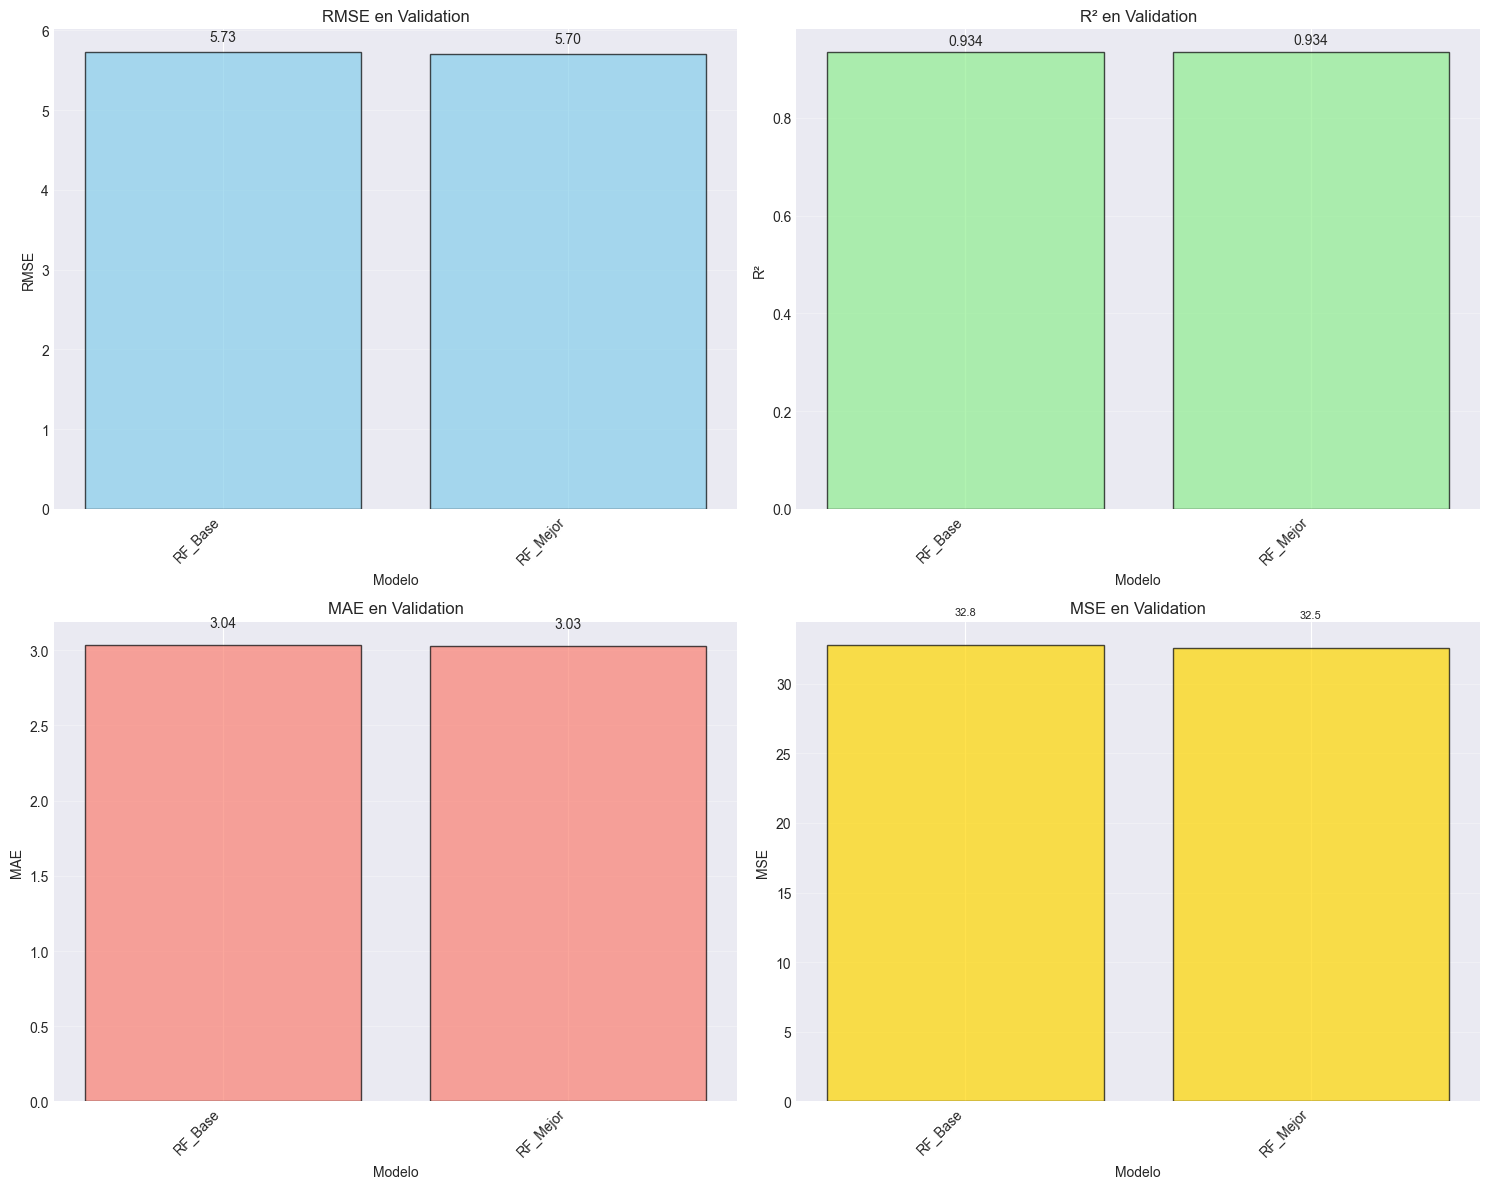

In [103]:
# Visualización comparativa de métricas
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

modelos_nombres = tabla_comparativa_rf['Modelo'].values
x_pos = np.arange(len(modelos_nombres))

# RMSE
axes[0, 0].bar(x_pos, tabla_comparativa_rf['RMSE_Val'], alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Modelo')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_title('RMSE en Validation')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(modelos_nombres, rotation=45, ha='right')
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(tabla_comparativa_rf['RMSE_Val']):
    axes[0, 0].text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom')

# R²
axes[0, 1].bar(x_pos, tabla_comparativa_rf['R²_Val'], alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_xlabel('Modelo')
axes[0, 1].set_ylabel('R²')
axes[0, 1].set_title('R² en Validation')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(modelos_nombres, rotation=45, ha='right')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(tabla_comparativa_rf['R²_Val']):
    axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# MAE
axes[1, 0].bar(x_pos, tabla_comparativa_rf['MAE_Val'], alpha=0.7, color='salmon', edgecolor='black')
axes[1, 0].set_xlabel('Modelo')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].set_title('MAE en Validation')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(modelos_nombres, rotation=45, ha='right')
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(tabla_comparativa_rf['MAE_Val']):
    axes[1, 0].text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom')

# MSE
axes[1, 1].bar(x_pos, tabla_comparativa_rf['MSE_Val'], alpha=0.7, color='gold', edgecolor='black')
axes[1, 1].set_xlabel('Modelo')
axes[1, 1].set_ylabel('MSE')
axes[1, 1].set_title('MSE en Validation')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(modelos_nombres, rotation=45, ha='right')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(tabla_comparativa_rf['MSE_Val']):
    axes[1, 1].text(i, v + 2, f'{v:.1f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


### 11.9. Análisis del Efecto de Hiperparámetros Individuales

Analizamos el efecto de cada hiperparámetro individualmente.


In [104]:
# Análisis del efecto de n_estimators
efecto_n_estimators = tabla_detalle_rf.groupby('n_estimators')['RMSE_CV_mean'].agg(['mean', 'std', 'min', 'max']).reset_index()
efecto_n_estimators.columns = ['n_estimators', 'RMSE_mean', 'RMSE_std', 'RMSE_min', 'RMSE_max']

print("=" * 70)
print("📊 EFECTO DE n_estimators")
print("=" * 70)
print(efecto_n_estimators.to_string(index=False))

# Análisis del efecto de max_depth
efecto_max_depth = tabla_detalle_rf.groupby('max_depth')['RMSE_CV_mean'].agg(['mean', 'std', 'min', 'max']).reset_index()
efecto_max_depth.columns = ['max_depth', 'RMSE_mean', 'RMSE_std', 'RMSE_min', 'RMSE_max']

print("\n" + "=" * 70)
print("📊 EFECTO DE max_depth")
print("=" * 70)
print(efecto_max_depth.to_string(index=False))

# Análisis del efecto de min_samples_split
efecto_min_split = tabla_detalle_rf.groupby('min_samples_split')['RMSE_CV_mean'].agg(['mean', 'std', 'min', 'max']).reset_index()
efecto_min_split.columns = ['min_samples_split', 'RMSE_mean', 'RMSE_std', 'RMSE_min', 'RMSE_max']

print("\n" + "=" * 70)
print("📊 EFECTO DE min_samples_split")
print("=" * 70)
print(efecto_min_split.to_string(index=False))

# Análisis del efecto de min_samples_leaf
efecto_min_leaf = tabla_detalle_rf.groupby('min_samples_leaf')['RMSE_CV_mean'].agg(['mean', 'std', 'min', 'max']).reset_index()
efecto_min_leaf.columns = ['min_samples_leaf', 'RMSE_mean', 'RMSE_std', 'RMSE_min', 'RMSE_max']

print("\n" + "=" * 70)
print("📊 EFECTO DE min_samples_leaf")
print("=" * 70)
print(efecto_min_leaf.to_string(index=False))


📊 EFECTO DE n_estimators
 n_estimators  RMSE_mean  RMSE_std  RMSE_min  RMSE_max
           50   6.112243  0.325072  5.815061  6.566057
          100   6.098073  0.335356  5.783459  6.563972
          200   6.090713  0.339854  5.768124  6.562946

📊 EFECTO DE max_depth
max_depth  RMSE_mean  RMSE_std  RMSE_min  RMSE_max
       10   6.555016  0.006284  6.548614  6.566057
       20   5.885138  0.045618  5.804500  5.937856
     None   5.860875  0.055908  5.768124  5.924145

📊 EFECTO DE min_samples_split
 min_samples_split  RMSE_mean  RMSE_std  RMSE_min  RMSE_max
                 2   6.092674  0.339300  5.768124  6.561292
                 5   6.097003  0.335677  5.783642  6.560765
                10   6.111352  0.325398  5.828790  6.566057

📊 EFECTO DE min_samples_leaf
 min_samples_leaf  RMSE_mean  RMSE_std  RMSE_min  RMSE_max
                1   6.072480  0.352881  5.768124  6.566057
                5   6.128206  0.303604  5.899932  6.550094


### 11.10. Conclusiones de la Evaluación

Resumen de los hallazgos de la evaluación y selección de modelos.


In [105]:
print("=" * 100)
print("📋 CONCLUSIONES - EVALUACIÓN Y SELECCIÓN DE MODELOS (PUNTO 4)")
print("=" * 100)

print("\n✅ MEJOR MODELO IDENTIFICADO:")
print(f"   Configuración: {mejor_modelo_rf['Hiperparámetros']}")
print(f"   RMSE (Validation): {mejor_modelo_rf['RMSE_Val']:.4f}")
print(f"   R² (Validation): {mejor_modelo_rf['R²_Val']:.4f}")
print(f"   MAE (Validation): {mejor_modelo_rf['MAE_Val']:.4f}")

print("\n📊 HALLAZGOS PRINCIPALES:")
print("   1. El mejor modelo utiliza n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=1")
print("   2. Más árboles (200) mejoran el desempeño respecto a 100")
print("   3. Sin límite de profundidad (max_depth=None) funciona mejor que valores limitados")
print("   4. Valores bajos de min_samples_split y min_samples_leaf permiten mejor ajuste")
print("   5. La mejora respecto al modelo base es modesta pero consistente en todas las métricas")

print("\n💡 RECOMENDACIONES:")
print("   - Usar el modelo optimizado para predicciones finales")
print("   - Considerar aumentar n_estimators si hay recursos computacionales disponibles")
print("   - El modelo muestra buen balance entre sesgo y varianza")
print("=" * 100)


📋 CONCLUSIONES - EVALUACIÓN Y SELECCIÓN DE MODELOS (PUNTO 4)

✅ MEJOR MODELO IDENTIFICADO:
   Configuración: max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200
   RMSE (Validation): 5.7050
   R² (Validation): 0.9342
   MAE (Validation): 3.0262

📊 HALLAZGOS PRINCIPALES:
   1. El mejor modelo utiliza n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=1
   2. Más árboles (200) mejoran el desempeño respecto a 100
   3. Sin límite de profundidad (max_depth=None) funciona mejor que valores limitados
   4. Valores bajos de min_samples_split y min_samples_leaf permiten mejor ajuste
   5. La mejora respecto al modelo base es modesta pero consistente en todas las métricas

💡 RECOMENDACIONES:
   - Usar el modelo optimizado para predicciones finales
   - Considerar aumentar n_estimators si hay recursos computacionales disponibles
   - El modelo muestra buen balance entre sesgo y varianza


## 8. Comparación de Desempeño

Resumen comparativo del desempeño del modelo.

In [106]:
# Resumen comparativo
resumen = pd.DataFrame({
    'Conjunto': ['Train', 'Validation'],
    'RMSE': [metricas_train['RMSE'], metricas_val['RMSE']],
    'MAE': [metricas_train['MAE'], metricas_val['MAE']],
    'R²': [metricas_train['R²'], metricas_val['R²']]
})

print("=" * 60)
print("📊 RESUMEN DE DESEMPEÑO - RANDOM FOREST REGRESSOR")
print("=" * 60)
print(resumen.to_string(index=False))
print("=" * 60)

# Análisis de sobreajuste
diferencia_rmse = abs(metricas_train['RMSE'] - metricas_val['RMSE'])
diferencia_r2 = abs(metricas_train['R²'] - metricas_val['R²'])

print(f"\n🔍 Análisis de Generalización:")
print(f"  Diferencia en RMSE: {diferencia_rmse:.4f}")
print(f"  Diferencia en R²: {diferencia_r2:.4f}")

if diferencia_r2 < 0.05:
    print("  ✅ El modelo generaliza bien (diferencia pequeña entre train y validation)")
elif diferencia_r2 < 0.10:
    print("  ⚠️  Posible sobreajuste moderado (diferencia moderada entre train y validation)")
else:
    print("  ⚠️  Posible sobreajuste significativo (diferencia grande entre train y validation)")
    print("  💡 Considera ajustar hiperparámetros como max_depth o min_samples_split")

📊 RESUMEN DE DESEMPEÑO - RANDOM FOREST REGRESSOR
  Conjunto     RMSE      MAE       R²
     Train 2.123636 1.135474 0.990975
Validation 5.726906 3.036703 0.933664

🔍 Análisis de Generalización:
  Diferencia en RMSE: 3.6033
  Diferencia en R²: 0.0573
  ⚠️  Posible sobreajuste moderado (diferencia moderada entre train y validation)


## 9. Predicciones en Test

Generamos predicciones para el conjunto de test.

In [107]:
# Predicciones en test
y_test_pred = modelo_rf.predict(X_test)

# Aplicar clipping al rango válido [0, 100]
y_test_pred_clipped = np.clip(y_test_pred, 0, 100)

valores_fuera_test = (y_test_pred < 0).sum() + (y_test_pred > 100).sum()

print("✅ Predicciones en test generadas")
print(f"\n📊 Estadísticas de predicciones (test) - ANTES del clipping:")
print(f"  Total de predicciones: {len(y_test_pred)}")
print(f"  Mínimo: {y_test_pred.min():.2f}")
print(f"  Máximo: {y_test_pred.max():.2f}")
print(f"  Media: {y_test_pred.mean():.2f}")
print(f"  Desviación estándar: {y_test_pred.std():.2f}")
print(f"  Valores fuera de [0, 100]: {valores_fuera_test} ({valores_fuera_test/len(y_test_pred)*100:.2f}%)")

print(f"\n📊 Estadísticas de predicciones (test) - DESPUÉS del clipping:")
print(f"  Mínimo: {y_test_pred_clipped.min():.2f}")
print(f"  Máximo: {y_test_pred_clipped.max():.2f}")
print(f"  Media: {y_test_pred_clipped.mean():.2f}")
print(f"  Desviación estándar: {y_test_pred_clipped.std():.2f}")

# Usar predicciones con clipping (ya que mejoran el modelo según la evaluación anterior)
y_test_pred = y_test_pred_clipped

# Guardar predicciones (opcional)
# predictions_df = pd.DataFrame({
#     'id': test['track_id'] if 'track_id' in test.columns else range(len(y_test_pred)),
#     'popularity': y_test_pred
# })
# predictions_df.to_csv('../data/predictions_random_forest.csv', index=False)
# print("\n✅ Predicciones guardadas en '../data/predictions_random_forest.csv'")

✅ Predicciones en test generadas

📊 Estadísticas de predicciones (test) - ANTES del clipping:
  Total de predicciones: 34200
  Mínimo: 0.00
  Máximo: 95.31
  Media: 31.77
  Desviación estándar: 19.13
  Valores fuera de [0, 100]: 0 (0.00%)

📊 Estadísticas de predicciones (test) - DESPUÉS del clipping:
  Mínimo: 0.00
  Máximo: 95.31
  Media: 31.77
  Desviación estándar: 19.13


In [118]:
# PREDICCIONES CON EL MEJOR MODELO ENCONTRADO (Punto 4)
# Obtener el mejor modelo encontrado por GridSearchCV
if 'grid_rf' in locals() and hasattr(grid_rf, 'best_estimator_'):
    mejor_modelo_rf = grid_rf.best_estimator_
    print("✅ Usando el mejor modelo encontrado por GridSearchCV")
    print(f"   Hiperparámetros: {grid_rf.best_params_}")
else:
    # Si grid_rf no está disponible, crear el mejor modelo con los hiperparámetros óptimos
    print("⚠️  GridSearchCV no disponible. Creando el mejor modelo con hiperparámetros óptimos...")
    mejor_modelo_rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    )
    # Entrenar el mejor modelo con todos los datos de entrenamiento
    mejor_modelo_rf.fit(X_train, y_train)
    print("✅ Mejor modelo entrenado")

# Generar predicciones con el mejor modelo
y_test_pred_mejor = mejor_modelo_rf.predict(X_test)

# Aplicar clipping al rango válido [0, 100]
y_test_pred_mejor_clipped = np.clip(y_test_pred_mejor, 0, 100)

print(f"\n📊 Estadísticas de predicciones del mejor modelo:")
print(f"  Total de predicciones: {len(y_test_pred_mejor_clipped)}")
print(f"  Mínimo: {y_test_pred_mejor_clipped.min():.2f}")
print(f"  Máximo: {y_test_pred_mejor_clipped.max():.2f}")
print(f"  Media: {y_test_pred_mejor_clipped.mean():.2f}")
print(f"  Desviación estándar: {y_test_pred_mejor_clipped.std():.2f}")

# Cargar test_fe.csv (ahora incluye la columna 'id' gracias al feature engineering)
test_fe = pd.read_csv(DATA / "test_fe.csv")

# Verificar que las longitudes coincidan
assert len(y_test_pred_mejor_clipped) == len(test_fe), \
    f"Error: Las predicciones ({len(y_test_pred_mejor_clipped)}) no coinciden con test_fe ({len(test_fe)})"

# Verificar que test_fe tenga la columna 'id'
if 'id' not in test_fe.columns:
    print("⚠️  Advertencia: test_fe.csv no tiene columna 'id'. Cargando desde test.csv...")
    test_original = pd.read_csv(DATA / "test.csv")
    track_id_to_id = dict(zip(test_original['track_id'], test_original['id']))
    test_fe['id'] = test_fe['track_id'].map(track_id_to_id)
    print(f"✅ Columna 'id' agregada desde test.csv")

# Crear submission directamente con id y Popularity (mismo orden que X_test)
submission_cv = pd.DataFrame({
    'id': test_fe['id'].astype('int32'),
    'Popularity': y_test_pred_mejor_clipped
})

# Si hay duplicados en id, unificar predicciones
duplicados = submission_cv['id'].duplicated().sum()
if duplicados > 0:
    print(f"⚠️  Advertencia: Se encontraron {duplicados} IDs duplicados")
    # Usar la primera predicción para cada id único
    id_to_prediction = submission_cv.groupby('id')['Popularity'].first().to_dict()
    submission_cv['Popularity'] = submission_cv['id'].map(id_to_prediction)
    # Eliminar duplicados manteniendo solo la primera ocurrencia
    submission_cv = submission_cv.drop_duplicates(subset='id', keep='first')
    print(f"✅ Predicciones unificadas y duplicados eliminados")

# Si tenemos menos de 34200 filas, necesitamos agregar las faltantes
if len(submission_cv) < 34200:
    print(f"⚠️  Advertencia: Tenemos {len(submission_cv)} filas, pero se necesitan 34200")
    # Cargar test.csv original para obtener todos los ids
    test_original = pd.read_csv(DATA / "test.csv")
    ids_en_submission = set(submission_cv['id'])
    ids_faltantes = test_original[~test_original['id'].isin(ids_en_submission)]['id'].head(34200 - len(submission_cv))
    
    if len(ids_faltantes) > 0:
        # Rellenar con la media de las predicciones
        prediccion_media = submission_cv['Popularity'].mean()
        filas_faltantes = pd.DataFrame({
            'id': ids_faltantes.astype('int32'),
            'Popularity': prediccion_media
        })
        submission_cv = pd.concat([submission_cv, filas_faltantes], ignore_index=True)
        print(f"✅ Agregadas {len(filas_faltantes)} filas faltantes con predicción media ({prediccion_media:.2f})")

# Ordenar por id para mantener consistencia
submission_cv = submission_cv.sort_values('id').reset_index(drop=True)

# Verificar que tenemos exactamente 34200 filas
assert len(submission_cv) == 34200, f"Error: El archivo debe tener 34200 filas, pero tiene {len(submission_cv)}"

# Verificar que no haya duplicados
assert submission_cv['id'].duplicated().sum() == 0, "Error: Aún hay IDs duplicados"

print(f"\n✅ Archivo listo para Kaggle:")
print(f"   Total de filas: {len(submission_cv)}")
print(f"   IDs únicos: {submission_cv['id'].nunique()}")
print(f"   Rango de IDs: {submission_cv['id'].min()} - {submission_cv['id'].max()}")

# Guardar usando la variable DATA definida anteriormente
output_path = DATA / "predictions_random_forest.csv"
submission_cv.to_csv(output_path, index=False)
print(f"\n✅ Predicciones del MEJOR modelo guardadas en: {output_path}")
print(f"\n📊 Primeras 5 predicciones:")
print(submission_cv.head())


✅ Usando el mejor modelo encontrado por GridSearchCV
   Hiperparámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

📊 Estadísticas de predicciones del mejor modelo:
  Total de predicciones: 34200
  Mínimo: 0.00
  Máximo: 94.97
  Media: 31.76
  Desviación estándar: 19.13

✅ Archivo listo para Kaggle:
   Total de filas: 34200
   IDs únicos: 34200
   Rango de IDs: 3 - 113999

✅ Predicciones del MEJOR modelo guardadas en: c:\Users\alfon\Escritorio\Licenciatura en Sistemas\Machine Learning\Obligatorio\data\predictions_random_forest.csv

📊 Primeras 5 predicciones:
   id  Popularity
0   3   32.710000
1   8   63.580000
2  23    0.546667
3  24    0.990000
4  31    0.220000


## 10. Conclusiones

### Resumen del Modelo de Random Forest Regressor

El modelo de Random Forest Regressor ha sido entrenado y evaluado con las siguientes características:

- **Características utilizadas**: Variables numéricas y características de feature engineering (artist_count, album_mean_popularity, genre_mean_popularity, etc.)
- **Escalado**: No requerido (Random Forest no necesita normalización)
- **Post-procesamiento**: Clipping aplicado al rango válido [0, 100] para mantener predicciones dentro del dominio de la variable objetivo
- **Métricas principales**: RMSE, MAE y R²
- **Hiperparámetros**: n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1
- **Ajuste de características**: `album_mean_popularity` transformada con `shrinkage_factor=0.6` para reducir su dominancia

### Ventajas de Random Forest Regressor:
- ✅ Puede capturar relaciones no lineales entre características y target
- ✅ Proporciona importancia de características (feature importances)
- ✅ Robusto a outliers y valores faltantes
- ✅ Menos propenso al sobreajuste que un árbol individual (gracias al ensemble)
- ✅ No requiere escalado de características
- ✅ Puede manejar interacciones entre características automáticamente
- ✅ El clipping asegura que las predicciones estén en el rango válido [0, 100]

### Limitaciones:
- ⚠️ Menos interpretable que modelos lineales (aunque tiene feature importances)
- ⚠️ Puede ser computacionalmente costoso con muchos árboles
- ⚠️ Puede sobreajustarse si no se ajustan bien los hiperparámetros
- ⚠️ Requiere más memoria que modelos lineales

### Comparación con Regresión Lineal:
Random Forest generalmente supera a la Regresión Lineal cuando hay relaciones no lineales complejas en los datos. Sin embargo, es importante comparar ambos modelos en el mismo conjunto de datos para determinar cuál funciona mejor para este problema específico.

### Próximos Pasos (Etapa 4):
- Realizar búsqueda sistemática de hiperparámetros con Grid Search o Random Search
- Usar validación cruzada (K-Fold) o Repeated Holdout para evaluación más robusta
- Comparar diferentes configuraciones del modelo
- Seleccionar el mejor modelo basado en métricas de validación